In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import sklearn
import os
import os
import numpy as np
import concurrent.futures
from skimage.feature import hog
from skimage import exposure
from skimage.feature import local_binary_pattern
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from PIL import Image
import sys


os.environ['MOMAPS_HOME'] = '/home/labs/hornsteinlab/Collaboration/MOmaps'

sys.path.insert(1, os.getenv('MOMAPS_HOME'))
sys.path.insert(1, os.getenv("MOMAPS_HOME"))
print(f"MOMAPS_HOME: {os.getenv('MOMAPS_HOME')}")

from src.common.lib import image_metrics
from src.common.lib.preprocessing_utils import rescale_intensity, handle_img_shape

%reload_ext autoreload
%autoreload 2
%aimport

%matplotlib inline

MOMAPS_HOME: /home/labs/hornsteinlab/Collaboration/MOmaps
Modules to reload:
all-except-skipped

Modules to skip:



# Utils

In [2]:
# Load images
def get_npy_files(path):
    npy_files = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.npy'):
                npy_files.append(os.path.join(root, file))
    return npy_files

import skimage 

def get_metrics_processed(tile):
  metrics = ()
  for c in range(tile.shape[-1]):
    metrics += get_metrics(tile[...,c])
    
  return metrics

def get_metrics(tile, as_string=False):
    sharpness_brenner = image_metrics.calculate_image_sharpness_brenner(tile)    
    if as_string:
        return f"Brenner: {round(sharpness_brenner, 3)}"
    return sharpness_brenner

    snr = image_metrics.calculate_snr(tile)
    # Check contrast & Sharpness
    sharpness_laplacian = image_metrics.calculate_image_sharpness_laplacian(tile)
    # contrast = image_metrics.calculate_image_contrast(tile)
    # Check var
    var = image_metrics.calculate_var(tile)
    # Check blurness:
    # sharpness_brenner = image_metrics.calculate_image_sharpness_brenner(tile)    
    entropy = image_metrics.calculate_entropy(tile)
    sigma = image_metrics.calculate_sigma(tile)
    high_freq = image_metrics.calculate_high_freq_power(tile)
    # largest_area = calculate_largest_uniform_area(tile)
    # fractal_dim = calculate_fractal_dim(tile)
    # blur = image_metrics.calc_image_blur_effect(tile)
  
    if as_string:
          return f"SNR: {round(snr, 3)}, Sharpness Laplacian: {round(sharpness_laplacian, 3)}, Sharpness Brenner: {round(sharpness_brenner, 3)}, Variance: {var}, Entropy: {round(entropy, 3)}, Sigma: {round(sigma, 3)}, FFT freq: {round(high_freq, 3)}" 
  
    return snr,sharpness_laplacian,var,sharpness_brenner, entropy, sigma,high_freq #,largest_area
  

# def get_metrics_columns():
#   return ["Path", "Quality", "Target_SNR", "Target_Sharpness_Laplacian", "Target_Var",
#            'Target_Sharpness_Brenner', "Target_Entropy", "Target_Sigma", "Target_HighFreq", "DAPI_SNR", "DAPI_Sharpness_Laplacian",
#             "DAPI_Var", 'DAPI_Sharpness_Brenner', "DAPI_Entropy", "DAPI_Sigma", "DAPI_HighFreq"]


def run_dim_reduction(dim_red, images, labels=None, show=True):
  # Perform PCA
  images = images.reshape(images.shape[0], -1)
  reduced = dim_red.fit_transform(images)
  
  if not show:
    return reduced
  
  if labels is None:
    plt.scatter(reduced[:,0], reduced[:,1])
    plt.show()
    return reduced
  
  
  labels_unique = np.unique(labels)
  
  for l in labels_unique:
    indexes = labels == l
    plt.scatter(reduced[indexes,0], reduced[indexes,1], alpha=0.5)
  plt.legend(labels_unique)
  plt.show()
  
  return reduced 

def plot_images(images, vmin=0,vmax=1000):
    for i in range(len(images)):
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(images[i,...,0])#, vmin=vmin,vmax=vmax)
        ax[0].set_title("Target")
        ax[1].imshow(images[i,...,1])#, vmin=vmin,vmax=vmax)
        ax[1].set_title("Nucleus")
        plt.show()
        
def load_tiles(paths):
  paths_split = map(lambda x: (x.rsplit('_',1)[0], int(x.rsplit('_',1)[1])), paths.reshape(-1,))
  tiles = []
  for filename, tile_number in paths_split:
    t = np.load(filename)[tile_number, ...]
    tiles.append(t)
    
  tiles = np.stack(tiles)
  return tiles



def get_outliers(df, feature, split=False, iqrs=1.5):
    # Calculate Q1, Q3, and IQR
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    lower = df[feature] < Q1 - iqrs* IQR
    higher = df[feature] > Q3 + iqrs*IQR
    if split:
        # Determine outliers using IQR
        outliers_lower = df[lower]
        outliers_higher = df[higher]
        return outliers_lower, outliers_higher
    
    # Determine outliers using IQR
    outliers = df[(lower ) | (higher)]
    
    return outliers

def show_images(df, max_samples = 10):
    for ind, path in enumerate(df.Path.values):
        print(ind)
        if max_samples is not None and ind >= max_samples:
            print(f"Stopping at {ind}. There are {len(df.Path.values)} images in total")
            break
        
        # Target
        # target_path = os.path.join(d, path)
        # show_processed_tif(target_path)
        show_processed_tif(path)
        # His DAPI
        # path_l = target_path.split("/")
        # path_l[-2] = 'DAPI'
        
        # file_name = path_l[-1].split("_")
        # dapi_file_name = "_".join([file_name[0], 'w1confDAPI', file_name[-1]])
        # dapi_file_name = "/".join([*path_l[:-1], dapi_file_name])
        # print(dapi_file_name)

        # show_processed_tif(dapi_file_name)
        print('--------------------------------')
        
def get_dapi_file_name(path):
    site_path, tile_number = path.rsplit('_',1)
    path_l = site_path.split("/")
    path_l[-2] = 'DAPI'

    file_name = path_l[-1].split("_")
    dapi_file_name = "_".join([file_name[0], 'w1confDAPI', file_name[-1]])
    dapi_file_name = "/".join([*path_l[:-1], f'{dapi_file_name}_{tile_number}'])
    
    return dapi_file_name
        
def show_tiles(df, max_samples=10, rescale_tile=False):
    for ind, path in enumerate(df.Path.values):
        site_path, tile_number = path.rsplit('_',1)
        tile_number = int(tile_number)
        print(ind)
        if max_samples is not None and ind >= max_samples:
            print(f"Stopping at {ind}. There are {len(df.Path.values)} images in total")
            break
        
        # Target
        show_tile(site_path, tile_number, rescale_tile)
        # His DAPI
        path_l = site_path.split("/")
        path_l[-2] = 'DAPI'
        
        file_name = path_l[-1].split("_")
        dapi_file_name = "_".join([file_name[0], 'w1confDAPI', file_name[-1]])
        dapi_file_name = "/".join([*path_l[:-1], dapi_file_name])
        print(dapi_file_name)

        show_tile(dapi_file_name, tile_number, rescale_tile)
        print('--------------------------------')
        
# def save_to_mapping(mappings, marker, metric_name, low_threshold, high_threshold):
#     mappings[marker] = {
#         metric_name: {
#             'low_threshold': low_threshold,
#             'high_threshold': high_threshold
#         }
#     }

def init_mappings(markers=[], filepath=None):
    if filepath is not None:     
        if os.path.exists(filepath):
            mappings = pd.read_csv(filepath, index_col=0)
            return mappings
        
    mappings = pd.DataFrame(columns=['Site_brenner_lower_bound', 'Site_brenner_upper_bound'], index=markers)

    return mappings
        
def save_to_mapping(filepath, mappings, marker, value, is_upper_bound):
    col = 'Site_brenner_upper_bound' if is_upper_bound else 'Site_brenner_lower_bound' 
    mappings.loc[marker, col] = value
    
    mappings.to_csv(filepath)
    print(f"File saved to {filepath}")
    
    
def processed_path_to_raw_paths(path):
    path_splited = path.split(os.sep)
    filename = path_splited[-1]
    filename_split = filename.split('_')
    rep = filename_split[0]
    panel = filename_split[4]
    line = filename_split[5]
    filename_new = '_'.join(filename_split[1:4])
    batch = path_splited[-5]
    batch = batch.split('_')[0]
    cond = path_splited[-3]
    marker = path_splited[-2]
    
    ret = os.path.join("/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/raw/SpinningDisk", batch, line, panel, cond, rep, marker, f'{filename_new}.tif')
    return ret

def raw_path_to_processed_path(path):
    path_splited = path.split(os.sep)
    filename = os.path.splitext(path_splited[-1])[0]
    rep = path_splited[-3]
    panel = path_splited[-5]
    line = path_splited[-6]
    batch = path_splited[-7]
    batch = f"{batch}_16bit_no_downsample"
    cond = path_splited[-4]
    marker = path_splited[-2]
    
    ret = os.path.join("/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/processed/spd2/SpinningDisk/", batch, line, cond, marker, f'{rep}_{filename}_{panel}_{line}_processed.npy')
    return ret


# d = '/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/raw/SpinningDisk/'

def show_label(path):
    path_l = path.split("/")
    return os.sep.join(path_l[-8:])
    
def show_processed_tif(path):
    # read the image stack
    img = cv2.imread(path, cv2.IMREAD_ANYDEPTH) 
    img = handle_img_shape(img, 1024, 1024)
    # rescale pixel intensities
    img = rescale_intensity(img)
    
    # show the image with grid 
    fig, ax = plt.subplots(figsize=(7,7))
    plt.imshow(img, cmap='gray')
    put_tiles_grid(image=img, ax=ax)
    plt.axis('off')
    plt.title(show_label(path), color='purple')
    print(get_metrics(img, True))
    print(f"Img shape: {img.shape}")
    plt.show()
    
def show_tile(site_path, tile_number, rescale_tile=False):
    # read the image stack
    img = cv2.imread(site_path, cv2.IMREAD_ANYDEPTH) 
    img = handle_img_shape(img, 1024, 1024)
    # rescale pixel intensities
    img = rescale_intensity(img)
    
    row_ind = tile_number // 10
    col_ind = tile_number % 10
    img = img[row_ind * 100 : (row_ind + 1) * 100, col_ind * 100 : (col_ind + 1) * 100]
    
    print(f"img shape: {np.asarray(img).shape}")
    
#     # Check dead cells?
#     img_uint8 = img.astype(np.uint8)
#     # Apply Gaussian blur
# #     gray_blurred = cv2.GaussianBlur(img_uint8, (9, 9), 0)

#     # Apply Hough Circle Transform
#     # Adjust the parameters, especially minRadius and maxRadius, to detect small circles
#     circles = cv2.HoughCircles(img_uint8, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=0, maxRadius=0)
   
    
    if rescale_tile:
        print("NOTICE! Rescaling also the tile!!!!!")
        img = rescale_intensity(img)
    
    fig, ax = plt.subplots(figsize=(7,7))
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    
#     if circles is not None:
#         print(f"circles count: {len(circles)}")
#         circles = np.uint16(np.around(circles))
#         for i in circles[0, :]:
#             center = (i[0], i[1])  # circle center
#             radius = i[2]  # circle radius
#             cv2.circle(image, center, radius, (0, 255, 0), 2)
    
#     put_tiles_grid(image=img, ax=ax)
    plt.axis('off')
    plt.title(show_label(site_path), color='purple')
    print(get_metrics(img, True))
    plt.show()
    
def crop_frame(original_image):
    # Crop the image by removing a 12-pixel frame from each side
    cropped_image = original_image[12:1012, 12:1012]  
    return cropped_image

def crop_site_to_tiles(img):
    from skimage.util import view_as_blocks
    # Break the cropped image into 64 tiles of size 100x100
    tile_size = 100
    num_tiles = 64

    # Reshape the image into tiles using view_as_blocks from skimage
    tiles = view_as_blocks(img, block_shape=(tile_size, tile_size, 3))

    for i in range(8):
        for j in range(8):
            tile = tiles[i, j]
    return 

def put_tiles_grid(image, ax):
    # assumes 1000x1000 image
    import matplotlib.patches as patches

    # Add dashed grid lines for 64 blocks
    num_blocks = 10
    block_size = 100

    for i in range(1, num_blocks):
        # Draw horizontal dashed lines
        ax.plot([0, 1000], [i * block_size, i * block_size], linestyle='--', lw=1, alpha=0.5, color='pink')

        # Draw vertical dashed lines
        ax.plot([i * block_size, i * block_size], [0, 1000], linestyle='--', lw=1, alpha=0.5, color='pink')

    # Remove x and y axis labels
    ax.set_xticks([])
    ax.set_yticks([])

    # Add a title
    plt.title('Image with Dashed Grid of 64 Blocks')

    
    


# Main

In [3]:
# df = pd.read_csv("/home/labs/hornsteinlab/Collaboration/MOmaps_Sagy/MOmaps/sandbox/outliers_detection/raw_metrics_all_batches_all_metrics_site_fix.csv")
# df = pd.read_csv("/home/labs/hornsteinlab/Collaboration/MOmaps_Sagy/MOmaps/sandbox/outliers_detection/raw_metrics_all_batches_brenner_site_dNLS.csv")
# df = pd.read_csv("/home/labs/hornsteinlab/Collaboration/MOmaps/sandbox/outliers_detection/brenner_values/raw_metrics_fus_fixed200224_2.csv")

# df = pd.read_csv("/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/preprocessing/spd/brenner/raw_metrics250324.csv")
# df = pd.read_csv("/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/preprocessing/Opera/brenner/raw_metrics250324.csv")

df = pd.read_csv("/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/preprocessing/Opera18Days_Reimaged/brenner/raw_metrics_230724.csv")

df

,Path,RootFolder,Marker,Condition,CellLine,Batch_Rep,Rep,Batch,Target_Sharpness_Brenner
0,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,CLTC,Untreated,FUSHeterozygous,batch1/rep1,rep1,batch1,8099.0083
1,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,CLTC,Untreated,FUSHeterozygous,batch1/rep1,rep1,batch1,2664.0767
2,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,CLTC,Untreated,FUSHeterozygous,batch1/rep1,rep1,batch1,3039.5660
3,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,CLTC,Untreated,FUSHeterozygous,batch1/rep1,rep1,batch1,2971.1616
4,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,CLTC,Untreated,FUSHeterozygous,batch1/rep1,rep1,batch1,1992.9904
...,...,...,...,...,...,...,...,...,...
163995,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,VDAC1,stress,WT,batch2/rep2,rep2,batch2,895.5183
163996,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,VDAC1,stress,WT,batch2/rep2,rep2,batch2,1183.0674
163997,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,VDAC1,stress,WT,batch2/rep2,rep2,batch2,2423.5884
163998,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,/home/labs/hornsteinlab/Collaboration/MOmaps/i...,VDAC1,stress,WT,batch2/rep2,rep2,batch2,2610.2566


In [4]:
# df['Marker'].value_counts()

In [5]:
# mappings = {}
counts = df['Marker'].value_counts()
all_markers = df['Marker'].unique()
print(len(all_markers))
print(all_markers)

30
['CLTC' 'DAPI' 'PSD95' 'FMRP' 'Phalloidin' 'SQSTM1' 'AGO2' 'CD41' 'TDP43'
 'HNRNPA1' 'PSPC1' 'Tubulin' 'Calreticulin' 'LAMP1' 'ANXA11' 'SNCA'
 'G3BP1' 'PURA' 'TOMM20' 'FUS' 'NCL' 'GM130' 'KIF5A' 'DCP1A' 'NEMO'
 'PEX14' 'PML' 'mitotracker' 'NONO' 'VDAC1']


In [6]:
mappings_filepath = "/home/labs/hornsteinlab/Collaboration/MOmaps/src/preprocessing/sites_validity_bounds_opera18days_reimaged.csv"
mappings = init_mappings(markers=all_markers, filepath=mappings_filepath)
mappings

,Site_brenner_lower_bound,Site_brenner_upper_bound
CLTC,500.00,8441.09
DAPI,190.00,2600.00
PSD95,300.00,19824.18
FMRP,101.71,3700.00
Phalloidin,350.00,8631.92
SQSTM1,145.60,5682.47
AGO2,175.46,25234.76
CD41,200.00,13688.33
TDP43,138.45,18686.30
HNRNPA1,100.00,19175.08


In [7]:
reference_filepath = None

In [8]:
# Load mappings from previous file
reference_filepath =  "/home/labs/hornsteinlab/Collaboration/MOmaps/src/preprocessing/sites_validity_bounds_opera18days.csv"
reference_mapping = init_mappings(markers=all_markers, filepath=reference_filepath)
reference_mapping

,Site_brenner_lower_bound,Site_brenner_upper_bound
CLTC,882.96,9554.10
DAPI,189.94,2743.42
PSD95,2195.85,27559.11
FMRP,662.11,3569.73
Phalloidin,649.92,8077.10
SQSTM1,1272.77,4256.61
AGO2,1074.52,27323.56
CD41,1844.58,11841.97
TDP43,246.22,2031.93
HNRNPA1,103.35,1401.92


In [9]:
# table_data = {
#     'CLTC': (1500, 20000),
#     'DAPI': (200, 7500),
#     'PSD95': (9771, 35041),
#     'FMRP': (1500, 10000),
#     'Phalloidin': (1702, 16000),
#     'SQSTM1': (2870, 17930),
#     'CD41': (4962, 20000),
#     'NONO': (0, 10000), #None to 0
#     'TDP43': (823, 14039),
#     'Calreticulin': (2000, 28313),
#     'LAMP1': (2171, 11318),
#     'ANXA11': (0, 14633),#None to 0
#     'SNCA': (3529, 23953),  
#     'G3BP1': (0, 9945),#None to 0
#     'KIF5A': (2118, 13717),  
#     'PURA': (2248, 7703),  
#     'FUS': (421, 7748), 
#     'NCL': (544, 4067),  
#     'GM130': (0, 4284),#None to 0
#     'TOMM20': (4042, 44385),
#     'DCP1A': (0, 14931),  #None to 0
#     'NEMO': (15491, 44143),  
#     'PEX14': (3353, 20000), 
#     'PML': (2000, 21338), 
#     'mitotracker': (5270, 20000) 
# }

Plot distribution

In [10]:
# import seaborn as sns

# # Plotting
# plt.figure(figsize=(20,8))
# sns.boxplot(x='Marker', y='Target_Sharpness_Brenner', data=df)
# plt.xticks(rotation=45)
# plt.title('Brenner Values per marker')

# plt.show()

# Set Brenner

ERROR:root:img shape (1080, 1080) is not devisable by 1024 (trying to do cropping)


marker = mitotracker, max_samples = 10, is upper bound: True
per: 100% (=7111.1143) (per_second_bound=100%, =7111.1143)
Number of mitotracker images in threshold 7111.1143 (100%) (and 7111.1143 (100%)): 1



0
Brenner: 7111.11376953125
Img shape: (1024, 1024)


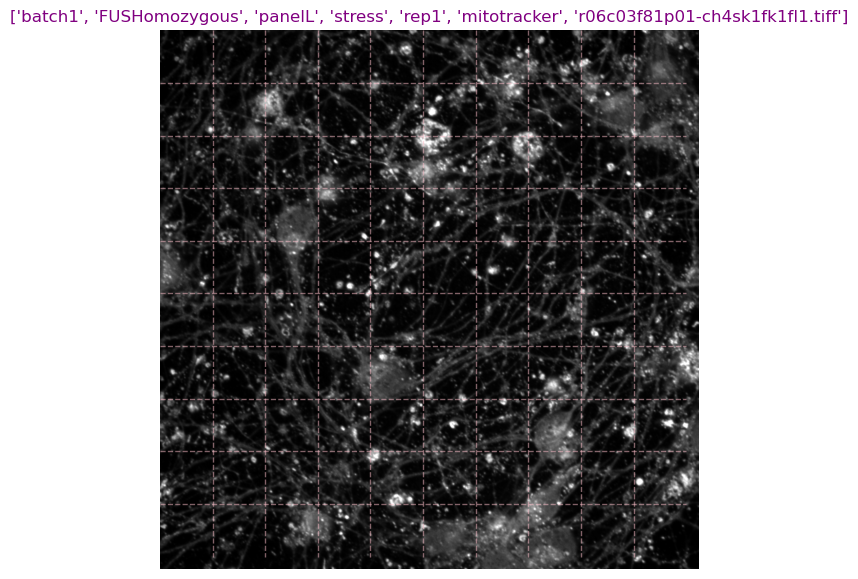

--------------------------------
File saved to /home/labs/hornsteinlab/Collaboration/MOmaps/src/preprocessing/sites_validity_bounds_opera18days_reimaged.csv


In [154]:
#################### SAFE ZONE TO CHANGE ###############

marker = 'mitotracker' # MARKERNAME
# [marker] Options:
# ['CLTC', 'DAPI', 'PSD95', 'FMRP', 'Phalloidin', 'SQSTM1', 'AGO2',
#        'CD41', 'TDP43', 'HNRNPA1', 'PSPC1', 'Tubulin', 'Calreticulin',
#        'LAMP1', 'ANXA11', 'SNCA', 'G3BP1', 'PURA', 'TOMM20', 'FUS', 'NCL',
#        'GM130', 'KIF5A', 'DCP1A', 'NEMO', 'PEX14', 'PML', 'mitotracker',
#        'NONO', 'VDAC1']


# [per] Options: 0-100
per = 100 # percentile threshold 

# [per] Options: 0-100
# *Optional! if you want to view images between per and another threshold
per_second_bound = None

# Whether to use reference mapping threshold
use_reference_mapping = False

# If set to true, per & per_second_bound will behave as percentile, otherwise as an exact value
use_percentiles = True

max_samples = 10 # set max number of images (in threshold) to show

# [is_upper_bound] Options:
# True: upper bound
# False: lower bound
is_upper_bound = True

show_percentile_plot = False

###################### END OF SAFE ZONE ###################





#########################################

if per_second_bound is None:
    if  use_percentiles:
        per_second_bound = 100 if is_upper_bound else 0
    else:
        per_second_bound = np.inf if is_upper_bound else -np.inf

print(f"marker = {marker}, max_samples = {max_samples}, is upper bound: {is_upper_bound}")

metric_name = 'Target_Sharpness_Brenner'
percentiles_to_describe = np.arange(0, 1.01, 0.01)
df_marker = df.loc[df['Marker'] == marker]
percentiles = df_marker[metric_name].describe(percentiles=percentiles_to_describe)
per_val = percentiles[f'{per}%'] if use_percentiles else per
per_second_bound_val = percentiles[f'{per_second_bound}%'] if use_percentiles else per_second_bound

if not use_reference_mapping:
    print(f"per: {per}{'%' if use_percentiles else ''} (={per_val}) (per_second_bound={per_second_bound}{'%' if use_percentiles else ''}, ={per_second_bound_val})")


if not use_reference_mapping:
    threshold = percentiles[f"{per}{'%' if use_percentiles else ''}"] if use_percentiles else per
    threshold_second = percentiles[f"{per_second_bound}{'%' if use_percentiles else ''}"] if use_percentiles else per_second_bound

    if is_upper_bound:
        c = (df_marker[metric_name]>=threshold) & (df_marker[metric_name]<=threshold_second)
    else:
        c = (df_marker[metric_name]<=threshold) & (df_marker[metric_name]>=threshold_second) 
else:
    print(f"Using reference mapping for marker {marker}:\n {reference_mapping.loc[marker]}")
    if is_upper_bound:
        c = (df_marker[metric_name]>=reference_mapping.loc[marker, 'Site_brenner_upper_bound'])
    else:
        c = (df_marker[metric_name]<=reference_mapping.loc[marker, 'Site_brenner_lower_bound'])

# threshold
df_marker_filtered = df_marker[c]
# shuffle
df_marker_filtered = df_marker_filtered.sample(frac=1, random_state=1)

print(f"Number of {marker} images in threshold {threshold} ({per}{'%' if use_percentiles else ''}) (and {threshold_second} ({per_second_bound}{'%' if use_percentiles else ''})): {len(df_marker_filtered)}")
print("\n\n")

if show_percentile_plot:
    plt.figure(figsize=(15,6))
    plt.plot(percentiles.keys().to_numpy()[4:-1], percentiles.values[4:-1])
    plt.ylabel('value')
    plt.xlabel('percentile')
    plt.xticks(rotation=90)
    plt.show()

show_images(df_marker_filtered, max_samples=max_samples)    

save_to_mapping(mappings_filepath, mappings, marker, round(threshold,2), is_upper_bound)


-----------------------------------------------------

#### Check the final numbers 

In [153]:
mappings

,Site_brenner_lower_bound,Site_brenner_upper_bound
CLTC,500.00,8441.09
DAPI,190.00,2600.00
PSD95,300.00,19824.18
FMRP,101.71,3700.00
Phalloidin,350.00,8631.92
SQSTM1,145.60,5682.47
AGO2,175.46,25234.76
CD41,200.00,13688.33
TDP43,138.45,18686.30
HNRNPA1,100.00,2648.64


In [ ]:
import scipy

# percentiles_to_describe=[0,.003,0.005,0.01,0.02,0.03,0.04,0.05,.06,0.07,.08,.09,0.1,.11,.12,.13,.14,.15]
percentiles_to_describe=[.16,.17,.18,.19,.20,.28,.29,.3,.31,.32,.33,.49,.5,.51,.60,.61,.62,.63,.64,.65,.66,.67,.68,.69,.70,.71,.72,.73,.75,.76,.77,.78,.79,.80,.81,.85,.86,.87,.88,.89,.90,.91,.92,.93,.94,.95,.955,.96,.965,.97,.975, .98,.985,.99,1]
marker = 'NONO'
metric_name = 'Target_Sharpness_Brenner'
percentiles = df.loc[df['Marker']==marker, metric_name].describe(percentiles=percentiles_to_describe)
per = 98

# box_plot_percentile = df.loc[df['Marker']==marker, metric_name].describe(percentiles=[.25,.75])
# boxplot_upper_bound = box_plot_percentile["75%"] + 1.5 * scipy.stats.iqr(df.loc[df['Marker']==marker, metric_name])
# boxplot_lower_bound = box_plot_percentile["25%"] - 1.5 * scipy.stats.iqr(df.loc[df['Marker']==marker, metric_name])

# print(f"boxplot_lower_bound = {boxplot_lower_bound}, boxplot_upper_bound = {boxplot_upper_bound},")

# low_threshold = table_data[marker][0]#percentiles[f'{per}%'] # for cellular debris
# high_threshold = table_data[marker][1] #15000#percentiles[f'{per}%'] # for out of focus


# low_threshold =percentiles[f'{per}%'] # for cellular debris
high_threshold = percentiles[f'{per}%'] # for out of focus

# low_threshold = boxplot_lower_bound
# high_threshold = 14000.0#2572.455155#23015.740327#boxplot_upper_bound#30000#table_data[marker][1] #15000#percentiles[f'{per}%'] # for out of focus


# per = 1
# low_threshold = percentiles[f'{per}%'] # for cellular debris
# high_threshold = percentiles[f'{per}%']#table_data[marker][1] #15000#percentiles[f'{per}%'] # for out of focus


# per = "From Mapping"
# low_threshold = markers_dict[marker]['lower_bound'] # debris
# high_threshold = markers_dict[marker]['upper_bound'] # out of focus

max_samples =10

# print(marker, metric_name, low_threshold, high_threshold, f'({per}%)')
# print()
# print(marker, '\n', percentiles)


# c = (df[metric_name]<=low_threshold) #& (df[metric_name]>=percentiles[f'20%'])  
c = (df[metric_name]>=high_threshold) #& (df[metric_name]<=percentiles[f'{per+1}%'] ) #& (df[metric_name]<=25000) # & (df[metric_name]<=percentiles[f'{per+1}%'] )

# c = (df[metric_name]<=9771) & (df[metric_name]>=low_threshold)  
# c = (df[metric_name]>=high_threshold) & (df[metric_name]<=30000 ) #& (df[metric_name]<=25000) # & (df[metric_name]<=percentiles[f'{per+1}%'] )


tmp = df[c]
# print(tmp.shape)
tmp = tmp[(tmp.Marker==marker)]

tmp = tmp.sample(frac=1, random_state=1)

print(tmp.shape, round(tmp.shape[0] * 100.0/counts[marker], 3), 100-round(tmp.shape[0] * 100.0/counts[marker], 3))


plt.figure(figsize=(15,6))
plt.plot(percentiles.keys().to_numpy()[4:-1], percentiles.values[4:-1])
plt.xticks(rotation=90)
plt.show()

show_images(tmp, max_samples=max_samples)    

save_to_mapping(mappings, marker, metric_name, low_threshold, high_threshold)

print("The thresholds map:")
mappings


In [ ]:
# Print top brenners per marker
max_samples = 5
df_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/preprocessing/Opera/brenner/raw_metrics250324.csv"

print(f"max_samples = {max_samples}")

df = pd.read_csv(df_path)
print(df.shape)

markers = df['Marker'].unique()
print(markers.shape)

for marker in markers:
    print(marker)
    df_marker = df.loc[df['Marker'] == marker]
    print(f"df_marker shape: {df_marker.shape}")
    df_marker.sort_values('Target_Sharpness_Brenner', ascending=False, inplace=True)
    df_marker_subset = df_marker.iloc[:max_samples]
    show_images(df_marker_subset, max_samples=max_samples)   